In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and data transformation
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor 


import warnings
warnings.filterwarnings('ignore')

In [2]:
base_path = Path('/kaggle/input/iots-and-robotics-temperature-prediction/')

file_info = {
    'train': 'IOT_Train.csv',
    'test': 'IOT_Test.csv',
    'sample_submission': 'IOT_Submit.csv'
}

# Loop to read files and assign to variables
for var_name, file_name in file_info.items():
    file_path = base_path / file_name
    globals()[var_name] = pd.read_csv(file_path)

In [3]:
train.head(3)

,mac,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,longitude,time,humid,light,pm10,pm2.5,rainfall,wind_direct,wind_speed,temp
0,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-07-20 15:00:00+07:00,70.6,59.0,NaN,NaN,0.0,45.0,4.3,32.6
1,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-05-16 09:00:00+07:00,62.3,76.0,NaN,NaN,0.0,45.0,1.9,37.9
2,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-06-26 19:00:00+07:00,90.3,0.0,NaN,NaN,0.0,135.0,3.2,26.4


In [4]:
test.head(3)

,id,mac,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,longitude,time,humid,light,pm10,pm2.5,rainfall,wind_direct,wind_speed
0,1,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-05-23 04:00:00+07:00,88.9,1.0,NaN,NaN,0.0,180.0,2.3
1,2,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-05-12 16:00:00+07:00,85.0,40.0,NaN,NaN,0.3,135.0,1.5
2,3,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-06-20 03:00:00+07:00,88.9,7.0,NaN,NaN,0.0,157.5,0.0


In [7]:
sample_submission.head(3)

,id,temp
0,1,25.6
1,2,30.1
2,3,24.7


In [3]:
print(f"train shape: {train.shape}")
print(f"test shape: {test.shape}")
print(f"sample_submission shape: {sample_submission.shape}")

train shape: (13635, 19)
test shape: (3413, 19)
sample_submission shape: (3413, 2)


In [9]:
train.duplicated().sum()

0

In [12]:
feature_names = train.drop(columns=['temp']).columns
X = train.drop(columns=['temp'])
y = train['temp'] 

kf = KFold(n_splits=5, shuffle=True, random_state=115)
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (10908, 18)
X_val shape: (2727, 18)
y_train shape: (10908,)
y_val shape: (2727,)


In [13]:
X_train.isnull().sum()

mac                 0
station_name        0
tambon_code         0
tambon_namt         0
amphur_code         0
amphur_namt         0
province_code       0
province_namt       0
latitude            0
longitude           0
time                0
humid               0
light               0
pm10             5421
pm2.5            5421
rainfall            0
wind_direct         0
wind_speed          0
dtype: int64

In [14]:
missing_values = X_train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_percentage = (missing_values / len(X_train)) * 100

print(missing_percentage)

pm10     49.69747
pm2.5    49.69747
dtype: float64


In [17]:
columns_to_fill = missing_percentage[missing_percentage > 30].index
columns_to_fill

Index(['pm10', 'pm2.5'], dtype='object')

In [18]:
for column in columns_to_fill:
    if X_train[column].dtype == "float64" or X_train[column].dtype == "int64":
        X_train[column].fillna(X_train[column].mean(), inplace=True)
    else:

        X_train[column].fillna(X_train[column].mode()[0], inplace=True)
X_train.isnull().sum()

mac              0
station_name     0
tambon_code      0
tambon_namt      0
amphur_code      0
amphur_namt      0
province_code    0
province_namt    0
latitude         0
longitude        0
time             0
humid            0
light            0
pm10             0
pm2.5            0
rainfall         0
wind_direct      0
wind_speed       0
dtype: int64

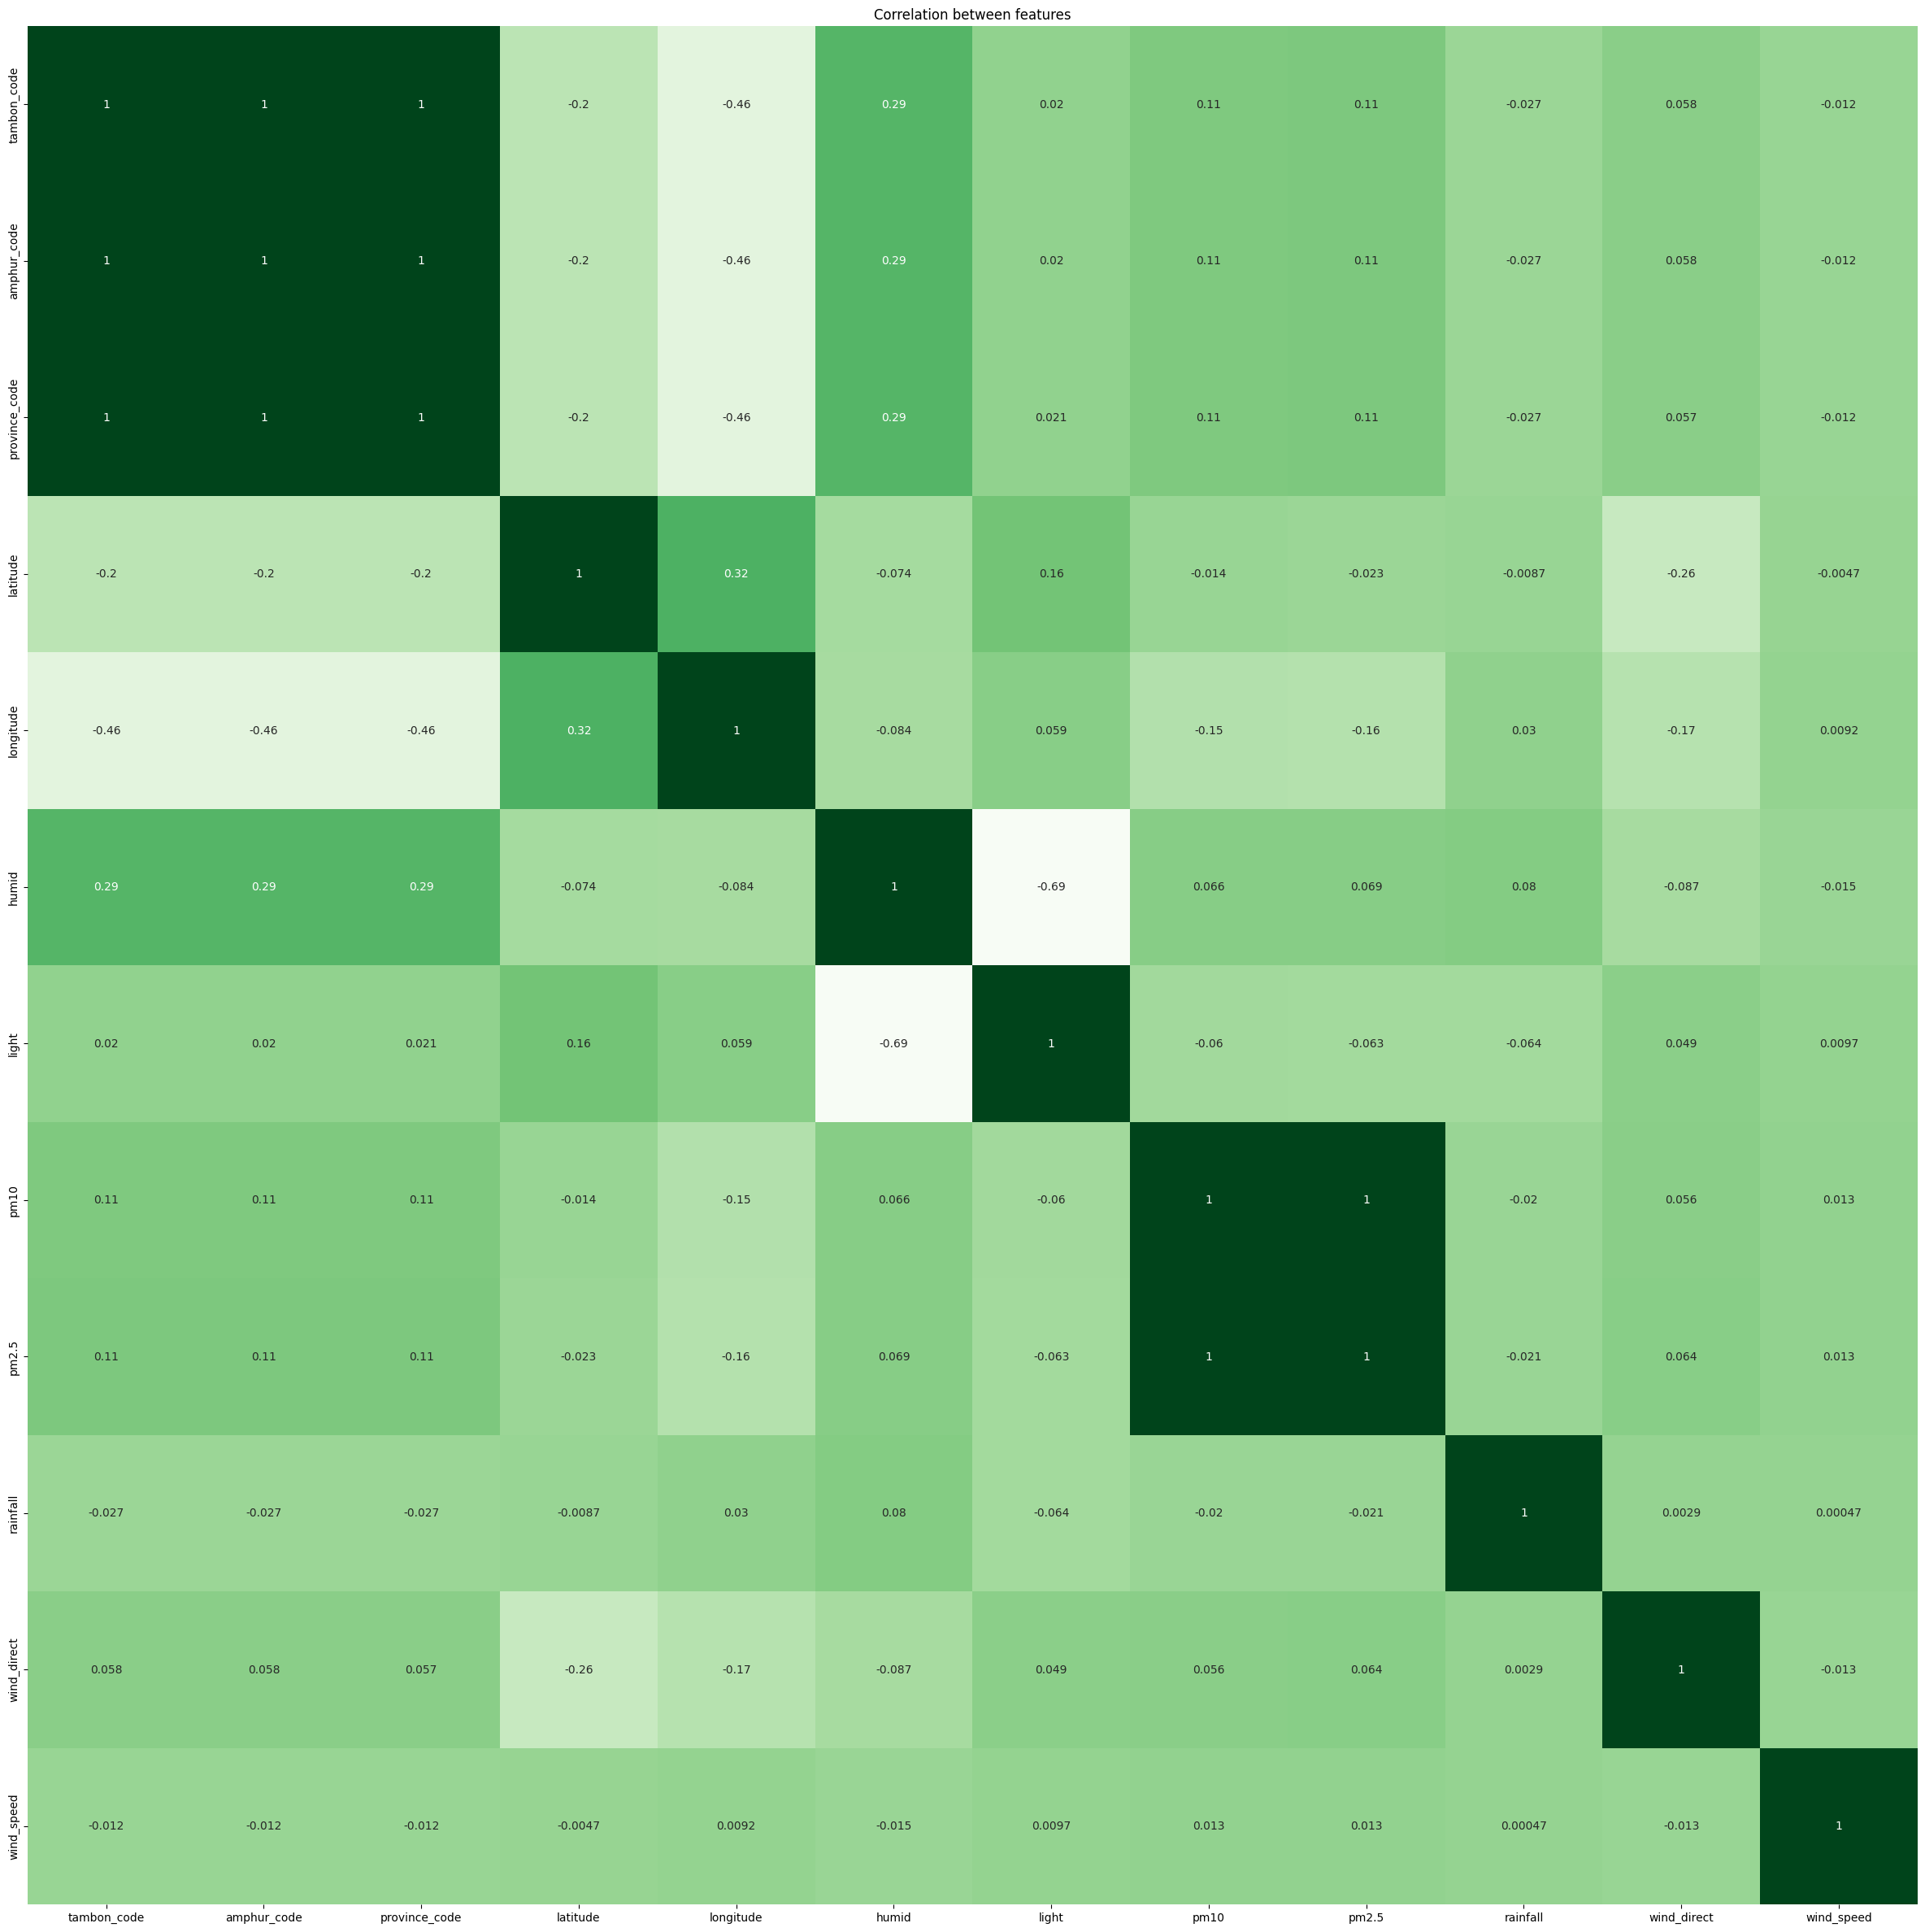

In [ ]:
num_data = X_train.select_dtypes(include=np.number).columns.tolist()
cat_data = X_train.select_dtypes(exclude=np.number).columns.tolist()

corr = X_train[num_data].corr()
plt.subplots(1,1, figsize=(30,30))
sns.heatmap(data=corr, cmap ='Greens', annot = corr, cbar=None)
plt.title('Correlation between features')
plt.show()

In [ ]:
fig, ax = plt.subplots(len(num_data), 1, figsize=(6, 50))
for axs, feature in zip(ax, num_data):
    X_train[[feature]].boxplot(ax=axs)